In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os
from orbitize import results, plot
from astropy import units as u
from astropy.time import Time
from scipy import stats

# TODO:
# 1. make dreamplot for fits 1B, 2A, 2B
# 2. run all 9 fits for 10x longer
# 4. why didn't radio-only fit #3 latch onto pm?
# 5. rerun fits #5, and make corner & parallax plots for them

# ALL FITS:
# 1a (standard + pl): True, 100, 5_000_000, False, False, True, True, False
# 1b (standard): True, 100, 5_000_000, False, False, False, True, False
# 2a (Hip only + pl): False, 100, 5_000_000, False, False, True, True, False
# 2b (Hip only): False, 100, 5_000_000, False, False, False, True, False
# 3 (radio only): True, 100, 5_000_000, False, False, False, False, False
# 4a: (not run)
# 4b: (not run)
# 5a (no bad Hip + pl): True, 100, 25_000_000, False, False, True, True, True
# 5b (no bad Hip): True, 100, 25_000_000, False, False, False, True, True

# Observations:
# - In 1A and 1B, including a planet systematically forces parallax to be slightly lower— more consistent with Harper result.
# - No parameter is strictly constrained by period limit, except sma and mass of betelgeuse which are constrained by Kepler’s third law. I am interpreting this to mean that the scale of the noise is constraining the secondary parameters.

# load results
fit_radio = True
burn = 100
total_steps = 5_000_000
renormHIP = False
dvd = False
planet = True
fit_hipparcos = True
no_bad_hipparcos = False

run_name = "planet{}_dvd{}_renormHIP{}_fitradio{}_fithipparcos{}".format(
    planet, dvd, renormHIP, fit_radio, fit_hipparcos
)
if no_bad_hipparcos:
    run_name += "_nofirstIAD"

run_name += "_burn{}_total{}".format(burn, total_steps)

beetle_results = results.Results()
beetle_results.load_results("results/{}.hdf5".format(run_name))

# create new dir for plots about this run
savedir = "plots/{}".format(run_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)

Make corner plot, secondary mass plot, and period plot:

{'per1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'pm_ra': 7, 'pm_dec': 8, 'alpha0': 9, 'delta0': 10, 'm1': 11, 'm0': 12}


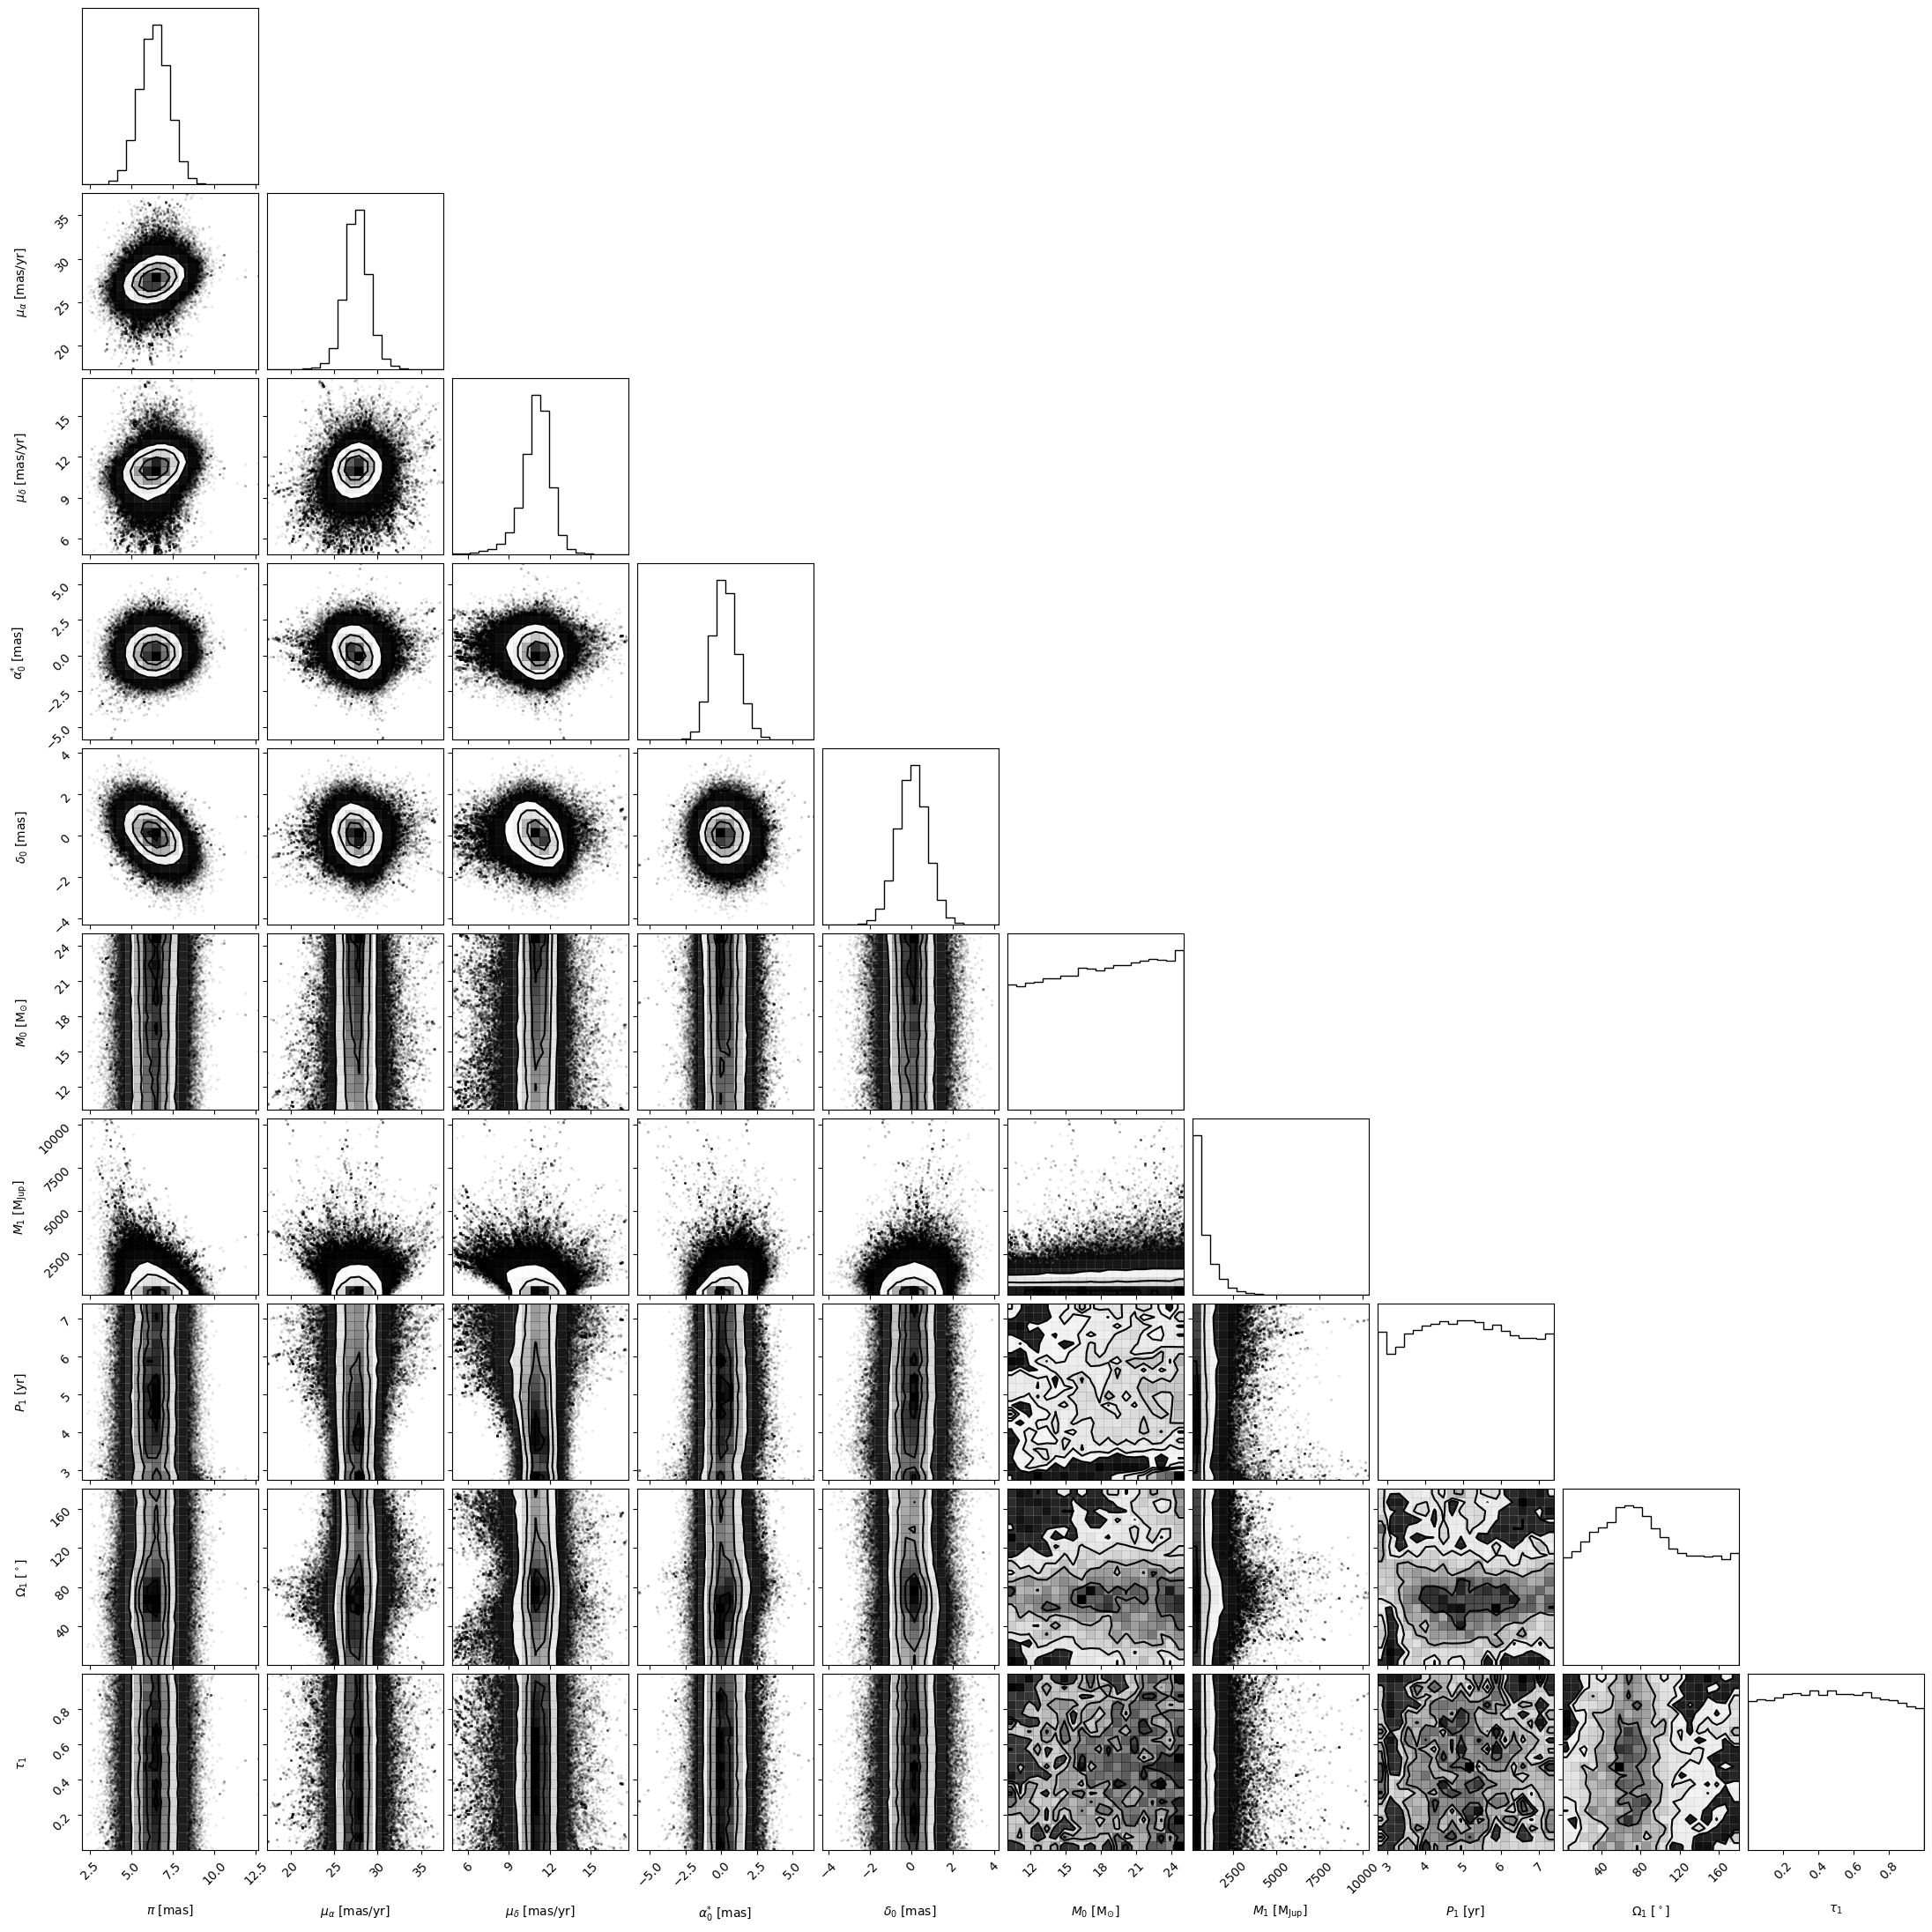

In [42]:
if not planet:
    param_list = ["plx", "pm_ra", "pm_dec", "alpha0", "delta0"]
else:
    param_list = [
        "plx",
        "pm_ra",
        "pm_dec",
        "alpha0",
        "delta0",
        "m0",
        "m1",
        "per1",
        "pan1",
        "tau1",
    ]

print(beetle_results.param_idx)
plot.plot_corner(beetle_results, param_list=param_list)
plt.savefig("{}/corner.png".format(savedir), dpi=250)

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_624011/3982771492.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("$\pi$ [mas]")


[5.46576972 6.34601464 7.22395948]


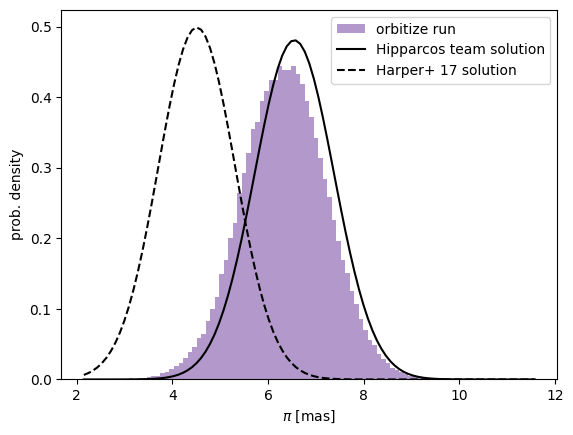

In [74]:
# compare parallax

plt.figure()
hts, bins, _ = plt.hist(
    beetle_results.post[:, beetle_results.system.param_idx["plx"]],
    bins=100,
    # label="Hipparcos-only, no error mods",
    label="orbitize run",
    density=True,
    color="rebeccapurple",
    alpha=0.5,
)

# overplot Hipparcos team solution
plt.plot(
    bins,
    stats.norm.pdf(bins, 6.55, 0.83),
    label="Hipparcos team solution",
    color="k",
)
plt.plot(
    bins,
    stats.norm.pdf(bins, 4.51, 0.80),
    label="Harper+ 17 solution",
    color="k",
    ls="--",
)
plt.legend()
plt.xlabel("$\pi$ [mas]")
plt.ylabel("prob. density")
plt.savefig("{}/plx.png".format(savedir), dpi=250)

plx_quantiles = np.quantile(
    beetle_results.post[:, beetle_results.system.param_idx["plx"]], [0.16, 0.5, 0.84]
)
print(plx_quantiles)

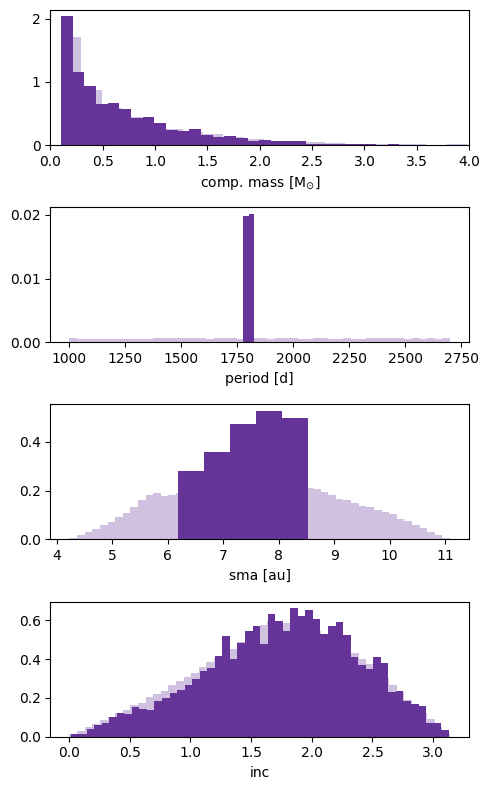

In [71]:
fig, ax = plt.subplots(4, 1, figsize=(5, 8))

# select subset of posterior consistent with RV period
p1 = 1800 / 365.25  # [yr]
p1_unc = 25 / 365.25  # [yr]
good_mask = (beetle_results.post[:, beetle_results.param_idx["per1"]] > p1 - p1_unc) & (
    beetle_results.post[:, beetle_results.param_idx["per1"]] < p1 + p1_unc
)

ax[0].hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]] * u.M_jup / u.M_sun,
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[0].hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]][good_mask]
    * u.M_jup
    / u.M_sun,
    bins=50,
    density=True,
    color="rebeccapurple",
)
ax[0].set_xlim(0, 4)
ax[0].set_xlabel("comp. mass [M$_{{\\odot}}$]")
ax[1].hist(
    beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25,
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[1].hist(
    beetle_results.post[:, beetle_results.param_idx["per1"]][good_mask] * 365.25,
    bins=2,
    density=True,
    color="rebeccapurple",
)
ax[1].set_xlabel("period [d]")
ax[2].hist(
    (
        (beetle_results.post[:, beetle_results.param_idx["per1"]]) ** 2
        * beetle_results.post[:, beetle_results.param_idx["m0"]]
    )
    ** (1 / 3),
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[2].hist(
    (
        (beetle_results.post[:, beetle_results.param_idx["per1"]][good_mask]) ** 2
        * beetle_results.post[:, beetle_results.param_idx["m0"]][good_mask]
    )
    ** (1 / 3),
    bins=5,
    density=True,
    color="rebeccapurple",
)
ax[2].set_xlabel("sma [au]")
ax[3].hist(
    beetle_results.post[:, beetle_results.param_idx["inc1"]],
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[3].hist(
    beetle_results.post[:, beetle_results.param_idx["inc1"]][good_mask],
    bins=50,
    density=True,
    color="rebeccapurple",
)
ax[3].set_xlabel("inc")

plt.tight_layout()
plt.savefig("{}/mass_period.png".format(savedir), dpi=250)

(0.0, 0.1)

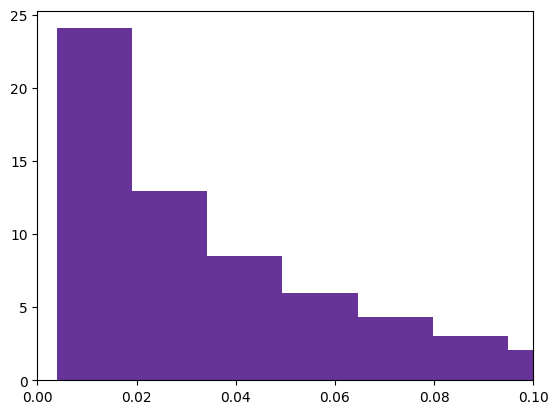

In [11]:
fig, ax = plt.subplots(1, 1)
ax.hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]]
    * u.M_jup
    / u.M_sun
    / beetle_results.post[:, beetle_results.param_idx["m0"]],
    bins=50,
    density=True,
    color="rebeccapurple",
)
ax.set_xlim(0, 0.1)

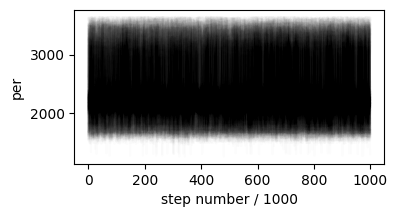

In [3]:
# make MCMC convergence plots
params = {"per1": "per"}
for param in params.keys():
    chn = beetle_results.post[:, beetle_results.system.param_idx[param]] * 365.25

    num_walkers = 1000
    n_steps = len(chn) // num_walkers
    chn = chn.reshape((num_walkers, n_steps))

    # TODO: fix x axis
    walkers_to_plot = np.random.choice(num_walkers, size=500, replace=False)
    plt.figure(figsize=(4, 2))
    chop_after = 0
    for w in walkers_to_plot:
        plt.plot(chn[w, :][chop_after:], color="k", alpha=0.01)
    plt.xlabel("step number / 1000")
    plt.ylabel(params[param])
    plt.savefig(
        "{}/per_chains.png".format(savedir),
        dpi=250,
    )

Compute amplitude of astrometric signal & goodness-of-fit:

<>:45: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_402487/805942552.py:45: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$decl. [mas]")
/tmp/ipykernel_402487/805942552.py:46: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta$RA [mas]")


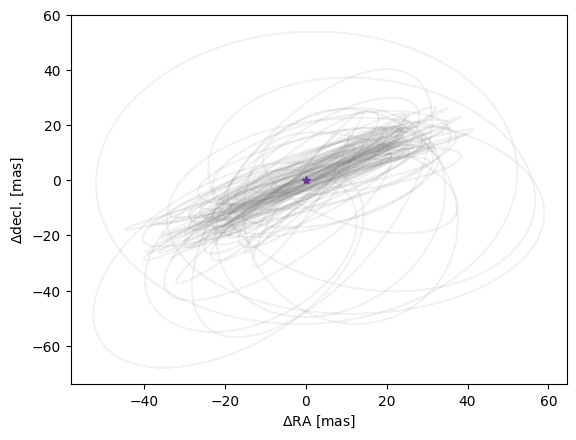

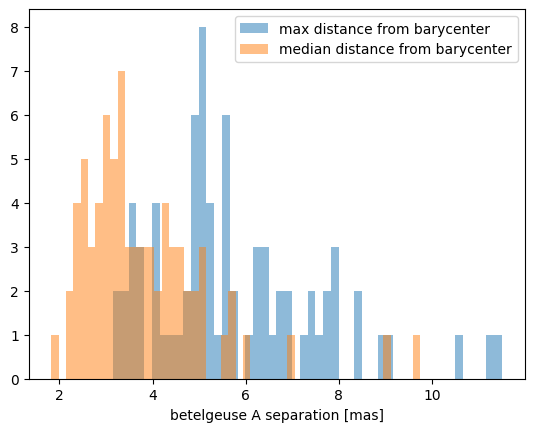

In [45]:
# calculate magnitude of astrometric signal over a single orbital period

# use calc_orbit to get relative ra/dec over epochs spanning 4000 d, multiply by m1/m0 to get mag of signal

epochs = np.linspace(0, 4000, int(1e3))

# for each orbit in a randomly selected 100 orbit subset of the posterior, solve the orbit
num2pick = 75
plot_indices = np.random.randint(0, len(beetle_results.post), size=num2pick)

raoff_orbit, deoff_orbit, _ = beetle_results.system.compute_all_orbits(
    beetle_results.post[plot_indices].T,
    epochs,
)
m0_posterior2plot = beetle_results.post[:, beetle_results.system.param_idx["m0"]][
    plot_indices
]
m1_posterior2plot = beetle_results.post[:, beetle_results.system.param_idx["m1"]][
    plot_indices
]

max_seps = np.empty(num2pick)
med_seps = np.empty(num2pick)
fig, ax = plt.subplots(1, 1)
for i in range(num2pick):

    plt.plot(
        raoff_orbit[:, 1, i],
        deoff_orbit[:, 1, i],
        alpha=0.1,
        lw=1,
        color="grey",
    )

    separations = (
        np.sqrt(raoff_orbit[:, 1, i] ** 2 + deoff_orbit[:, 1, i] ** 2)
        * m1_posterior2plot[i]
        / m0_posterior2plot[i]
    )
    max_seps[i] = np.max(separations)
    med_seps[i] = np.median(separations)

plt.plot([0], [0], marker="*", color="rebeccapurple")

plt.ylabel("$\Delta$decl. [mas]")
plt.xlabel("$\Delta$RA [mas]")
plt.savefig("{}/orbit_plot.png".format(savedir), dpi=250)

plt.figure()
plt.hist(max_seps, bins=50, label="max distance from barycenter", alpha=0.5)
plt.hist(med_seps, bins=50, label="median distance from barycenter", alpha=0.5)
plt.legend()
plt.xlabel("betelgeuse A separation [mas]")
plt.savefig("{}/astrom_signal_size.png".format(savedir), dpi=250)

# TODO: compute goodness-of-fit
# TODO: compute WAIC & compare to 1-body fit
# TODO: plot Betelgeuse angular size on top of orbits of companion

Visualize the fit:

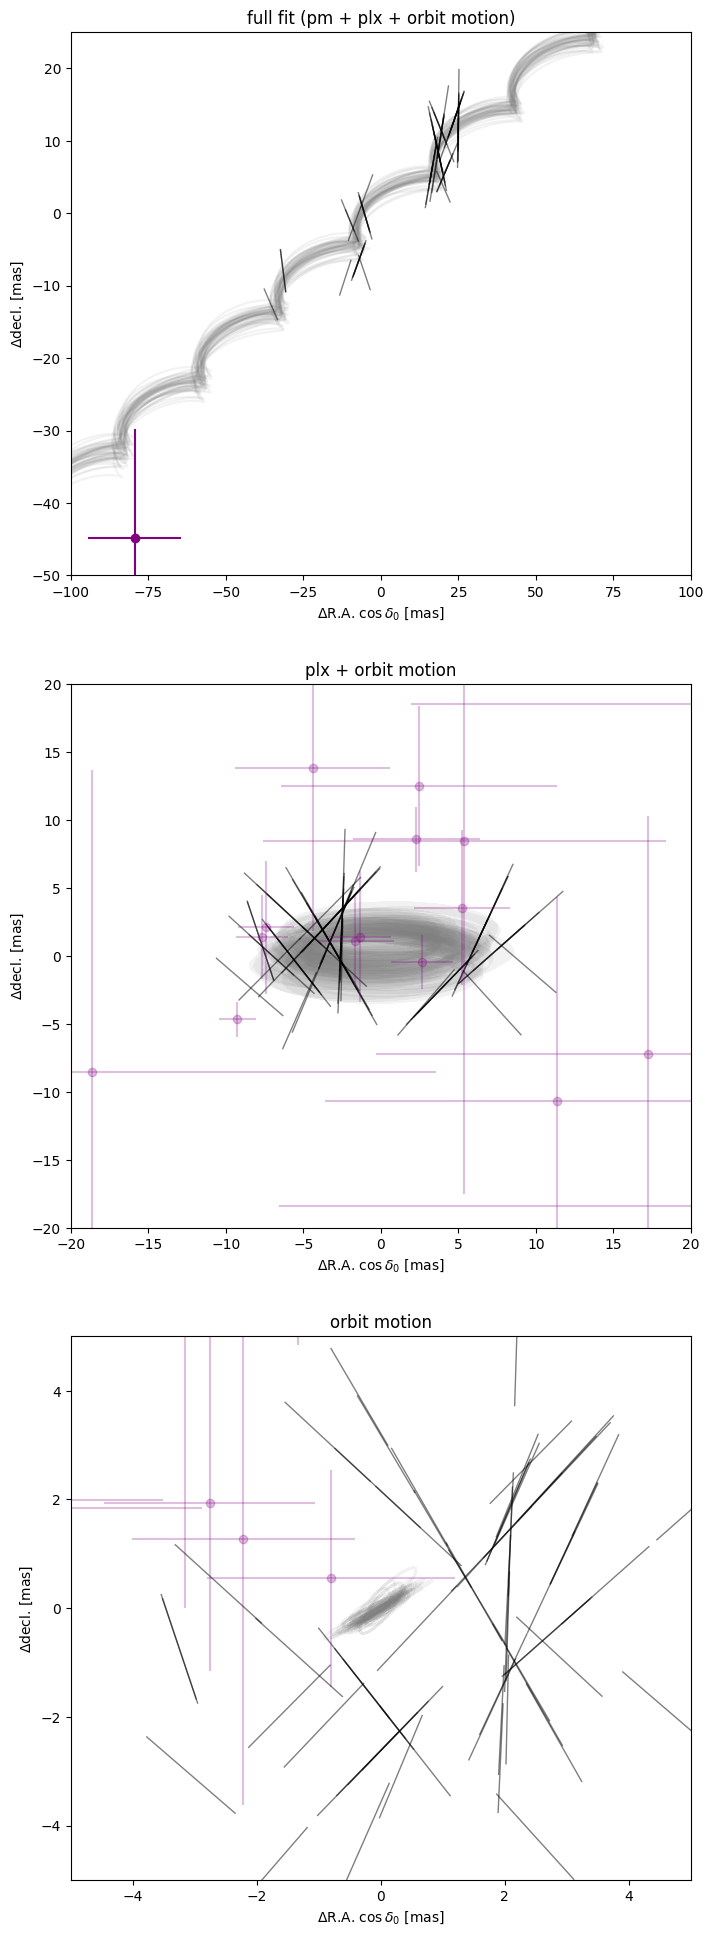

In [48]:
"""
VERSION 2
"""

# make a plot with showing the star's total motion. Thinking a la Nowak+ beta Pic c paper figure.

# panel 1: full fit, radio + IAD + random draws from posterior
# panel 2: median PM subtracted, data points overplotted. uncertainty in data
# points (in lighter color) includes uncertainty in model subtraction
# panel 3: median PM + parallax motion subtracted, data points overplotted. uncertainty
#  in data points (in darker color) includes uncertainty in model subtraction

ra_data = beetle_results.system.data_table["quant1"]
dec_data = beetle_results.system.data_table["quant2"]
ra_err_data = beetle_results.system.data_table["quant1_err"]
dec_err_data = beetle_results.system.data_table["quant2_err"]
epochs_data = beetle_results.system.data_table["epoch"]

fig, ax = plt.subplots(3, 1, figsize=(8, 24))

# pick some random orbits from the posterior
num2plot = 50

restricted_post = beetle_results.post[
    (beetle_results.post[:, beetle_results.system.param_idx["per1"]] > 1900 / 365.25)
    & (beetle_results.post[:, beetle_results.system.param_idx["per1"]] < 2600 / 365.25)
]

plot_indices = np.random.randint(0, len(restricted_post), size=num2plot)

epochs2plot = np.linspace(
    np.min(beetle_results.system.data_table["epoch"]) - 100,
    np.max(beetle_results.system.data_table["epoch"]) + 1000,
    int(1e3),
)

raoff_orbit, deoff_orbit, _ = beetle_results.system.compute_all_orbits(
    restricted_post[plot_indices].T,
    epochs2plot,
)
raoff_star = raoff_orbit[:, 0, :]
deoff_star = deoff_orbit[:, 0, :]

whole_racosdelta_model = np.empty((num2plot, len(epochs2plot)))
whole_dec_model = np.empty((num2plot, len(epochs2plot)))
cosdelta0 = np.cos(np.radians(beetle_results.system.hipparcos_IAD.delta0))
pmra_residuals = np.empty((num2plot, len(epochs_data)))
pmdec_residuals = np.empty((num2plot, len(epochs_data)))
pmplx_ra_residuals = np.empty((num2plot, len(epochs_data)))
pmplx_dec_residuals = np.empty((num2plot, len(epochs_data)))

for i in np.arange(num2plot):
    (
        raoff_cosdelta0_pmplx,
        deoff_pmplx,
    ) = beetle_results.system.pm_plx_predictor.compute_astrometric_model(
        beetle_results.post[plot_indices[i]],
        beetle_results.system.param_idx,
        epochs=Time(epochs2plot, format="mjd").decimalyear,
    )
    whole_racosdelta_model[i, :] = raoff_cosdelta0_pmplx + raoff_star[:, i] * cosdelta0
    whole_dec_model[i, :] = deoff_pmplx + deoff_star[:, i]
    ax[0].plot(
        whole_racosdelta_model[i, :],
        whole_dec_model[i, :],
        color="grey",
        alpha=0.1,
    )

    # plot model with PM subtracted
    pm_ra = beetle_results.post[plot_indices[i]][
        beetle_results.system.param_idx["pm_ra"]
    ]
    pm_racosdelta_prediction = (
        Time(epochs2plot, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_ra

    pm_dec = beetle_results.post[plot_indices[i]][
        beetle_results.system.param_idx["pm_dec"]
    ]
    pm_dec_prediction = (
        Time(epochs2plot, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_dec

    ax[1].plot(
        whole_racosdelta_model[i, :] - pm_racosdelta_prediction,
        whole_dec_model[i, :] - pm_dec_prediction,
        color="grey",
        alpha=0.1,
    )

    # compute residuals to PM only
    pm_racosdelta_prediction_fordata = (
        Time(epochs_data, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_ra
    pm_dec_prediction_fordata = (
        Time(epochs_data, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_dec

    pmdec_residuals[i, :] = dec_data - pm_dec_prediction_fordata
    pmra_residuals[i, :] = ra_data * cosdelta0 - pm_racosdelta_prediction_fordata

    # compute residuals to PM + plx
    post = beetle_results.post[plot_indices[i], :]
    post_zeromass = np.copy(post)
    post_zeromass[beetle_results.system.param_idx["m1"]] = 0

    pmplx_prediction_fordata = beetle_results.system.compute_model(post_zeromass)

    pmplx_ra_residuals[i, :] = ra_data - pmplx_prediction_fordata[0][:, 0]
    pmplx_dec_residuals[i, :] = dec_data - pmplx_prediction_fordata[0][:, 1]

    # plot only orbital motion of model
    ax[2].plot(
        raoff_star[:, i] * cosdelta0,
        deoff_star[:, i],
        color="grey",
        alpha=0.1,
    )


# plot IAD
plot_iad(ax[0])


# for each orbit, subtract the proper motion. Overplot obs errors in one color and std of subtraction in another
ax[0].errorbar(
    ra_data * cosdelta0,
    dec_data,
    xerr=ra_err_data,
    yerr=dec_err_data,
    ls="",
    color="purple",
    marker="o",
)

pm_racosdelta_prediction_forIAD = (
    Time(beetle_results.system.hipparcos_IAD.epochs_mjd, format="mjd").decimalyear
    - beetle_results.system.hipparcos_IAD.alphadec0_epoch
) * pm_ra
pm_dec_prediction_forIAD = (
    Time(beetle_results.system.hipparcos_IAD.epochs_mjd, format="mjd").decimalyear
    - beetle_results.system.hipparcos_IAD.alphadec0_epoch
) * pm_dec


plot_iad(
    ax[1], ra_model=pm_racosdelta_prediction_forIAD, dec_model=pm_dec_prediction_forIAD
)


# for each orbit, subtract the proper motion and parallax motion. Overplot obs errors in one color and std of subtraction in another
ax[1].errorbar(
    np.median(pmra_residuals, axis=0),
    np.median(pmdec_residuals, axis=0),
    xerr=ra_err_data,
    yerr=dec_err_data,
    color="purple",
    ls="",
    alpha=0.25,
    marker="o",
)
ax[2].errorbar(
    np.median(pmplx_ra_residuals, axis=0),
    np.median(pmplx_dec_residuals, axis=0),
    xerr=ra_err_data,
    yerr=dec_err_data,
    color="purple",
    ls="",
    alpha=0.25,
    marker="o",
)

racosdelta0_pmplx_IAD = np.zeros(
    (num2plot, len(beetle_results.system.hipparcos_IAD.epochs_mjd))
)
dec_pmplx_IAD = np.zeros(
    (num2plot, len(beetle_results.system.hipparcos_IAD.epochs_mjd))
)
for i in range(num2plot):
    ra, dec = beetle_results.system.pm_plx_predictor.compute_astrometric_model(
        restricted_post[i],
        beetle_results.system.param_idx,
        epochs=beetle_results.system.hipparcos_IAD.epochs,
    )

    racosdelta0_pmplx_IAD[i, :] = ra
    dec_pmplx_IAD[i, :] = dec

# TODO: the below is wrong; need to fix residual calculation.
plot_iad(
    ax[2],
    ra_model=np.median(racosdelta0_pmplx_IAD, axis=0),
    dec_model=np.median(dec_pmplx_IAD, axis=0),
    segment_halflength=1,
)


# ax[2, 0].errorbar(
#     epochs_data,
#     np.median(pmplx_ra_residuals, axis=0),
#     yerr=np.std(pmplx_ra_residuals, axis=0),
#     color="purple",
#     ls="",
#     marker="o",
# )

# ax[2, 1].errorbar(
#     epochs_data,
#     np.median(pmplx_dec_residuals, axis=0),
#     yerr=dec_err_data,
#     color="purple",
#     ls="",
#     alpha=0.25,
# )
# ax[2, 1].errorbar(
#     epochs_data,
#     np.median(pmplx_dec_residuals, axis=0),
#     yerr=np.std(pmplx_dec_residuals, axis=0),
#     color="purple",
#     ls="",
#     marker="o",
# )

# ax[2, 0].set_xlabel("epoch [mjd]")
# ax[2, 1].set_xlabel("epoch [mjd]")
for a in ax:
    a.set_xlabel("$\\Delta$R.A. $\\cos{\\delta_0}$ [mas]")
    a.set_ylabel("$\\Delta$decl. [mas]")
# ax[1, 0].set_ylim(-10, 10)


ax[0].set_ylim(-50, 25)
ax[0].set_xlim(-100, 100)

ax[1].set_ylim(-20, 20)
ax[1].set_xlim(-20, 20)

ax[2].set_xlim(-5, 5)
ax[2].set_ylim(-5, 5)


ax[0].set_title("full fit (pm + plx + orbit motion)")
ax[1].set_title("plx + orbit motion")
ax[2].set_title("orbit motion")

plt.savefig("{}/multipanel_plot.png".format(savedir), dpi=250)

Compare orbital phase of RV and astrometric orbits:

In [ ]:
from orbitize.basis import tau_to_tp
from radvel.basis import timeperi_to_timetrans


tau_post = beetle_results.post[:, beetle_results.param_idx["tau1"]]
per_post = beetle_results.post[:, beetle_results.param_idx["per1"]]
ecc_post = beetle_results.post[:, beetle_results.param_idx["ecc1"]]
aop_pl_post = beetle_results.post[:, beetle_results.param_idx["aop1"]]
pan_post = beetle_results.post[:, beetle_results.param_idx["pan1"]]
aop_st_post = aop_pl_post + np.pi
per_post_days = per_post * 365.25

match_per_mask = (per_post_days > 2000) & (per_post_days < 2500)

tP_post = tau_to_tp(tau_post, beetle_results.tau_ref_epoch, per_post)
tC_post = timeperi_to_timetrans(tP_post, per_post_days, ecc_post, aop_st_post)


after_date = after_date = Time(2018, format="decimalyear").mjd
num_periods = (after_date - tC_post) / per_post_days
num_periods = np.ceil(num_periods).astype(int)
tC_post += num_periods * per_post_days

fig, ax = plt.subplots(1, 1)
ax.hist(
    Time(tC_post, format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    label="all P",
    density=True,
)
# ax.hist(
#     Time(tC_post[match_per_mask], format="mjd").decimalyear,
#     bins=50,
#     color="pink",
#     histtype="step",
#     label="2000 d < P < 2500 d",
# )
ax.hist(
    Time(
        tC_post[match_per_mask & (np.degrees(pan_post) > 150)], format="mjd"
    ).decimalyear,
    bins=50,
    color="hotpink",
    histtype="step",
    label="2000 d < P < 2500 d AND $\\Omega_{{*}}$ ~ 50deg",
    density=True,
)
ax.legend()
ax.set_xlabel("first time of conj. after 2018 [yr]")
plt.savefig("{}/phase.png".format(savedir), dpi=250)

Compare the orbital angular momentum vector orientation with the star's:

In [ ]:
from scipy.stats import norm


def cos_i_mutual(orb_inc, st_inc, orb_pan, st_pan):
    """
    Ref: De Rosa, Dawson, Nielsen 2020, eq 24
    """
    return np.cos(orb_inc) * np.cos(st_inc) + np.sin(orb_inc) * np.sin(st_inc) * np.cos(
        orb_pan - st_pan
    )


inc_post = beetle_results.post[:, beetle_results.param_idx["inc1"]]
pan_post = beetle_results.post[:, beetle_results.param_idx["pan1"]]


# mutual_inc_posterior = cos_i_mutual(inc_post, st_inc, pan_post, st_pan)

"""
Ref for PAN of Betelgeuse:
https://www.aanda.org/articles/aa/full_html/2018/01/aa31761-17/T4.html
"""

beetle_rot_pan = [
    (48.0, 1.1),
    (47.6, 1.1),
    (49.5, 1.0),
    (47.9, 1.0),
    (51.9, 1.3),
    (50.6, 1.0),
    (45.5, 1.0),
    (45.8, 1.0),
]

fig, ax = plt.subplots(2, 1)
ax[0].hist(np.degrees(inc_post), bins=50, color="rebeccapurple", density=True)
ax[0].axvline(90, color="hotpink", ls="-.", label="edge on")
ax[0].legend()
ax[1].hist(np.degrees(pan_post) % 180, bins=50, color="rebeccapurple", density=True)

xs = np.linspace(25, 60, 200)
for i, (pan_est, pan_unc) in enumerate(beetle_rot_pan):
    gaussian_pdf = norm(pan_est, pan_unc).pdf(xs)
    ax[1].fill_between(
        xs,
        gaussian_pdf / 10,
        np.zeros_like(xs),
        color="hotpink",
        alpha=0.2,
        label="Kervella+ 17 meas.",
    )
    if i == 0:
        ax[1].legend()
ax[0].set_xlabel("inc [deg]")
ax[1].set_xlabel("$\Omega_{{\\mathrm{{B}}}}$ % 180 [deg]")
plt.tight_layout()
plt.savefig("{}/mutual_inc.png".format(savedir), dpi=250)

Compute the flux ratio & separation:

In [ ]:
from astropy.modeling.physical_models import BlackBody

# ref: Levesque+ 2020 fig2 (est. by eye at 6800 Angstroms)
betelgeuse_flux = 10 ** (-8.5) * u.erg / u.s / u.cm**2 / u.angstrom

# assumptions of companion properties based on Morgan's guesses
assumed_params = {"distance": 200 * u.pc, "teff": 7500 * u.K, "radius": 0.8 * u.R_sun}

bb = BlackBody(
    assumed_params["teff"], scale=1 * u.erg / u.s / u.cm**2 / u.angstrom / u.sr
)


def companion_flux(wavelen):
    flux = (
        bb(wavelen)
        * np.pi
        * u.sr
        * (assumed_params["radius"]) ** 2
        / (assumed_params["dist"]) ** 2
    )
    return flux.to(u.erg / u.s / u.cm**2 / u.AA)


total_mass_post = (
    beetle_results.post[:, beetle_results.param_idx["m0"]]
    + beetle_results.post[:, beetle_results.param_idx["m1"]]
)


sma_post_au = ((per_post**2) * total_mass_post) ** (1 / 3)
sma_post_solrad = (sma_post_au * u.au).to(u.R_sun).value
dist_post = 1e3 / beetle_results.post[:, beetle_results.param_idx["plx"]]

sep_post = (sma_post_au * u.au / (dist_post * u.pc)).to(
    u.mas, equivalencies=u.dimensionless_angles()
)

plt.figure()
plt.hist(sep_post, bins=50, density=True)
plt.xlabel("sep [mas]")
plt.savefig("{}/separation.png".format(savedir), dpi=250)

What are the other peaks in the period posterior? Are they harmonics?

-> new theory (TODO: check when longer fit finishes): peak at 4.5 years is a nonconvergence artifact

In [ ]:
from astropy.timeseries import LombScargle

per_post = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25


# total length of dataset
data_len = np.max(beetle_results.system.data_table["epoch"]) - np.min(
    beetle_results.system.data_table["epoch"]
)

# observation:
# - the peak at 3500d is sorta close to data_len / 4, and that peak is
#   nowhere near as high as the other two peaks (in the most converged version of my +planet fit)

# plot the window function
fig, ax = plt.subplots()
radio_epochs = beetle_results.system.data_table["epoch"]
hipparcos_epochs = beetle_results.system.hipparcos_IAD.epochs_mjd
all_epochs = np.sort(np.unique(np.concatenate([radio_epochs, hipparcos_epochs])))


myls = LombScargle(all_epochs, np.ones_like(all_epochs))
freq, power = myls.autopower(
    minimum_frequency=1 / 3500.0,
    maximum_frequency=1 / 1000.0,
    samples_per_peak=2000,
)

plt.plot(1 / freq, power / 300, color="blue", label="window function")
# plt.plot(freq - 0.00007, power * 5000, color="green")
plt.hist(per_post, alpha=0.5, density=True, bins=100, label="posterior")
print(
    "Maximum of the window function occurs at {:.2f} d.".format(
        1 / freq[np.argmax(power)]
    )
)

# ax.axvline(420 * 3, label="N * 420d", ls="--", color="red")
ax.axvline(420 * 4, ls="--", color="red")
# ax.axvline(420 * 5, ls="--", color="red")
# ax.axvline(420 * 6, ls="--", color="red")
# ax.axvline(420 * 7, ls="--", color="red")
ax.axvline(420 * 8, ls="--", color="red")
plt.legend()
plt.xlim(1400, 3600)
plt.xlabel("period [d]")
plt.ylabel("prob.")
plt.savefig("{}/period_window.png".format(savedir), dpi=250)

# observations:
# - at shorter periods, the window function has strong peaks at ~180 d, ~250 d,
#   and at longer periods, it's got strong peaks at 1800 and 1500 d.
# - I've tried plotting the window function and the actual posterior in
#   frequency space to see if the window function structure gets imprinted
#   on the posterior, but it doesn't line up exactly.


def print_alias(samp_per, actual_per):
    alias_per = 1 / (1 / samp_per - 1 / actual_per)
    print(alias_per)


print_alias(180, 420.0)

# TODO: try another fit with a smaller period range
# to see if the ~420d period shows up in the period posterior
# (on 2/26, ran a fit with period range 100-2600d).


# TODO: try fits with only Hipparcos and only radio to see which is driving the result

Re-compute the posterior given the fundamental mode/parallax constraints.

In [ ]:
# TODO

Update documentation :)

In [ ]:
# TODO


### PLOT GRAVEYARD:


In [ ]:
def plot_iad(
    ax,
    hipparcos_object=beetle_results.system.hipparcos_IAD,
    segment_halflength=3,
    ra_model=None,
    dec_model=None,
):
    """
    middle_ra and middle_dec are where to plot

    TODO: add IAD erorrs to this plot
    """

    cosphi = hipparcos_object.cos_phi
    sinphi = hipparcos_object.sin_phi
    if ra_model is None and dec_model is None:
        ra_model = np.zeros(len(cosphi))
        dec_model = np.zeros(len(cosphi))
    for i in range(len(hipparcos_object.alpha_abs_st)):
        ax.plot(
            np.array(
                [
                    hipparcos_object.alpha_abs_st[i] - segment_halflength * cosphi[i],
                    hipparcos_object.alpha_abs_st[i] + segment_halflength * cosphi[i],
                ]
            )
            - ra_model[i],
            np.array(
                [
                    hipparcos_object.delta_abs[i] - segment_halflength * sinphi[i],
                    hipparcos_object.delta_abs[i] + segment_halflength * sinphi[i],
                ]
            )
            - dec_model[i],
            color="black",
            alpha=0.5,
            # ls="",
            lw=1,
            marker="",
        )

    # get model prediction (ra, dec) at each hipparcos epoch
    # compute intersection of hipparcos scan with model prediction
    # plot intersection point plus/minus segment_length

In [ ]:
# make a plot with showing the star's total motion. Thinking a la Nowak+ beta Pic c paper figure.

# panel 1: full fit, radio + IAD + random draws from posterior
# panel 2: median PM subtracted, data points overplotted. uncertainty in data
# points (in lighter color) includes uncertainty in model subtraction
# panel 3: median PM + parallax motion subtracted, data points overplotted. uncertainty
#  in data points (in darker color) includes uncertainty in model subtraction


# TODO: add Hipparcos IAD to this figure
ra_data = beetle_results.system.data_table["quant1"]
dec_data = beetle_results.system.data_table["quant2"]
ra_err_data = beetle_results.system.data_table["quant1_err"]
dec_err_data = beetle_results.system.data_table["quant2_err"]
epochs_data = beetle_results.system.data_table["epoch"]

fig, ax = plt.subplots(3, 2, figsize=(30, 8), sharex=True)
plt.subplots_adjust(hspace=0)

# pick some random orbits from the posterior
num2plot = 50

restricted_post = beetle_results.post[
    (beetle_results.post[:, beetle_results.system.param_idx["per1"]] > 1900 / 365.25)
    & (beetle_results.post[:, beetle_results.system.param_idx["per1"]] < 2600 / 365.25)
]

plot_indices = np.random.randint(0, len(restricted_post), size=num2plot)

epochs2plot = np.linspace(
    np.min(beetle_results.system.data_table["epoch"]),
    np.max(beetle_results.system.data_table["epoch"]),
    int(1e3),
)

raoff_orbit, deoff_orbit, _ = beetle_results.system.compute_all_orbits(
    restricted_post[plot_indices].T,
    epochs2plot,
)
raoff_star = raoff_orbit[:, 0, :]
deoff_star = deoff_orbit[:, 0, :]

whole_racosdelta_model = np.empty((num2plot, len(epochs2plot)))
whole_dec_model = np.empty((num2plot, len(epochs2plot)))
cosdelta0 = np.cos(np.radians(beetle_results.system.hipparcos_IAD.delta0))
pmra_residuals = np.empty((num2plot, len(epochs_data)))
pmdec_residuals = np.empty((num2plot, len(epochs_data)))
pmplx_ra_residuals = np.empty((num2plot, len(epochs_data)))
pmplx_dec_residuals = np.empty((num2plot, len(epochs_data)))

for i in np.arange(num2plot):
    (
        raoff_cosdelta0_pmplx,
        deoff_pmplx,
    ) = beetle_results.system.pm_plx_predictor.compute_astrometric_model(
        beetle_results.post[plot_indices[i]],
        beetle_results.system.param_idx,
        epochs=Time(epochs2plot, format="mjd").decimalyear,
    )
    whole_racosdelta_model[i, :] = raoff_cosdelta0_pmplx + raoff_star[:, i] * cosdelta0
    whole_dec_model[i, :] = deoff_pmplx + deoff_star[:, i]
    ax[0, 0].plot(epochs2plot, whole_racosdelta_model[i, :], color="grey", alpha=0.1)
    ax[0, 1].plot(epochs2plot, whole_dec_model[i, :], color="grey", alpha=0.1)

    # plot model with PM subtracted
    pm_ra = beetle_results.post[plot_indices[i]][
        beetle_results.system.param_idx["pm_ra"]
    ]
    pm_racosdelta_prediction = (
        Time(epochs2plot, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_ra

    ax[1, 0].plot(
        epochs2plot,
        whole_racosdelta_model[i, :] - pm_racosdelta_prediction,
        color="grey",
        alpha=0.1,
    )

    pm_dec = beetle_results.post[plot_indices[i]][
        beetle_results.system.param_idx["pm_dec"]
    ]
    pm_dec_prediction = (
        Time(epochs2plot, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_dec

    ax[1, 1].plot(
        epochs2plot,
        whole_dec_model[i, :] - pm_dec_prediction,
        color="grey",
        alpha=0.1,
    )

    # compute residuals to PM only
    pm_racosdelta_prediction_fordata = (
        Time(epochs_data, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_ra
    pm_dec_prediction_fordata = (
        Time(epochs_data, format="mjd").decimalyear
        - beetle_results.system.hipparcos_IAD.alphadec0_epoch
    ) * pm_dec

    pmdec_residuals[i, :] = dec_data - pm_dec_prediction_fordata
    pmra_residuals[i, :] = ra_data * cosdelta0 - pm_racosdelta_prediction_fordata

    # compute residuals to PM + plx
    post = beetle_results.post[plot_indices[i], :]
    post_zeromass = np.copy(post)
    post_zeromass[beetle_results.system.param_idx["m1"]] = 0

    pmplx_prediction_fordata = beetle_results.system.compute_model(post_zeromass)

    pmplx_ra_residuals[i, :] = ra_data * cosdelta0 - pmplx_prediction_fordata[0][:, 0]
    pmplx_dec_residuals[i, :] = dec_data - pmplx_prediction_fordata[0][:, 1]

    # plot only orbital motion of model
    ax[2, 0].plot(epochs2plot, raoff_star[:, i] * cosdelta0, color="grey", alpha=0.1)
    ax[2, 1].plot(epochs2plot, deoff_star[:, i], color="grey", alpha=0.1)


# have: scan angle (self.cosphi/self.sinphi), abscissca(self.alpha_abs_st), time, unc (self.epc)


ax[0, 0].errorbar(
    epochs_data,
    ra_data * cosdelta0,
    yerr=ra_err_data,
    ls="",
    color="purple",
    marker="o",
)
ax[0, 1].errorbar(
    epochs_data,
    dec_data,
    yerr=dec_err_data,
    ls="",
    color="purple",
    marker="o",
)

# for each orbit, subtract the proper motion. Overplot obs errors in one color and std of subtraction in another
ax[1, 0].errorbar(
    epochs_data,
    np.median(pmra_residuals, axis=0),
    yerr=ra_err_data,
    color="purple",
    ls="",
    alpha=0.25,
)
ax[1, 0].errorbar(
    epochs_data,
    np.median(pmra_residuals, axis=0),
    yerr=np.std(pmra_residuals, axis=0),
    color="purple",
    ls="",
    marker="o",
)

ax[1, 1].errorbar(
    epochs_data,
    np.median(pmdec_residuals, axis=0),
    yerr=dec_err_data,
    color="purple",
    ls="",
    alpha=0.25,
)
ax[1, 1].errorbar(
    epochs_data,
    np.median(pmdec_residuals, axis=0),
    yerr=np.std(pmdec_residuals, axis=0),
    color="purple",
    ls="",
    marker="o",
)

# for each orbit, subtract the proper motion and parallax motion. Overplot obs errors in one color and std of subtraction in another
ax[2, 0].errorbar(
    epochs_data,
    np.median(pmplx_ra_residuals, axis=0),
    yerr=ra_err_data,
    color="purple",
    ls="",
    alpha=0.25,
)
ax[2, 0].errorbar(
    epochs_data,
    np.median(pmplx_ra_residuals, axis=0),
    yerr=np.std(pmplx_ra_residuals, axis=0),
    color="purple",
    ls="",
    marker="o",
)

ax[2, 1].errorbar(
    epochs_data,
    np.median(pmplx_dec_residuals, axis=0),
    yerr=dec_err_data,
    color="purple",
    ls="",
    alpha=0.25,
)
ax[2, 1].errorbar(
    epochs_data,
    np.median(pmplx_dec_residuals, axis=0),
    yerr=np.std(pmplx_dec_residuals, axis=0),
    color="purple",
    ls="",
    marker="o",
)

ax[2, 0].set_xlabel("epoch [mjd]")
ax[2, 1].set_xlabel("epoch [mjd]")
ax[1, 0].set_ylabel("$\\Delta$R.A. $\\cos{\\delta_0}$ [mas]")
ax[1, 1].set_ylabel("$\\Delta$decl. [mas]")
# ax[1, 0].set_ylim(-10, 10)

plt.savefig("{}/multipanel_plot.png".format(savedir), dpi=250)